In [109]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

In [111]:
df = pd.read_csv("/Users/arsh/Downloads/Loan Approval Categorical Synthetic Dataset.csv")

In [113]:
df = df.drop(df.columns[[0, -1]], axis=1)

In [115]:
# features = ["Credit_History", "Income_Level", "Loan_Amount", "Zip_Code", "Education_Level"]
# target   = "Approval_Prob"  # now continuous

X = df[["Credit_History", "Income_Level", "Loan_Amount", "Zip_Code", "Education_Level"]].values
y = df["Approval_Prob"].values.reshape(-1,1)

In [117]:
train_df, test_df = train_test_split(df, test_size=0.3, random_state=42)

# Keep a copy of unencoded test features for later
test_df_unencoded = test_df.copy()

In [121]:
mappings = {
    "Credit_History":   {"Bad":0, "Fair":1, "Good":2},
    "Income_Level":     {"Low":0, "Medium":1, "High":2},
    "Loan_Amount":      {"Small":2, "Medium":1, "Large":0},
    "Zip_Code":         {"Urban":0, "Suburban":1, "Rural":2},
    "Education_Level":  {"High School":0, "Bachelor":1, "Master":2}
}
features = list(mappings.keys())
target   = "Approval_Prob"

In [123]:
for col, mp in mappings.items():
    train_df[col] = train_df[col].map(mp)
    test_df[col]  = test_df[col].map(mp)

In [125]:
class CatRegDataset(Dataset):
    def __init__(self, X_cat, y_cont):
        self.X = torch.LongTensor(X_cat)
        self.y = torch.FloatTensor(y_cont.reshape(-1,1))
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [127]:
X_train = train_df[features].values
y_train = train_df[target].values
X_test  = test_df[features].values
y_test  = test_df[target].values


In [131]:
X_test

array([[1, 0, 2, 1, 1],
       [2, 1, 0, 1, 1],
       [1, 0, 2, 1, 0],
       ...,
       [1, 2, 1, 0, 0],
       [1, 1, 1, 1, 2],
       [1, 1, 1, 1, 2]])

In [129]:
train_ds = CatRegDataset(X_train, y_train)
test_ds  = CatRegDataset(X_test,  y_test)
train_dl = DataLoader(train_ds, batch_size=4, shuffle=True)
test_dl  = DataLoader(test_ds,  batch_size=4)


In [76]:
class CatRNNReg(nn.Module):
    def __init__(self, num_feats=5, n_categories=3, emb_dim=16, hidden_size=32):
        super().__init__()
        self.embed = nn.Embedding(n_categories, emb_dim)
        self.rnn   = nn.RNN(emb_dim, hidden_size, batch_first=True)
        self.head  = nn.Linear(hidden_size, 1)

    def forward(self, x):
        x_emb = self.embed(x)            # [B, num_feats, emb_dim]
        out, h_n = self.rnn(x_emb)       # out: [B, num_feats, hidden]
        last_h   = h_n[-1]               # [B, hidden]
        return self.head(last_h)         # [B,1]


In [78]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CatRNNReg().to(device)
opt   = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()


In [80]:
for epoch in range(1, 21):
    model.train()
    total_loss = 0.0
    for x_cat, y_cont in train_dl:
        x_cat, y_cont = x_cat.to(device), y_cont.to(device)
        pred = model(x_cat)
        loss = loss_fn(pred, y_cont)
        opt.zero_grad(); loss.backward(); opt.step()
        total_loss += loss.item() * x_cat.size(0)
    if epoch % 10 == 0:
        print(f"Epoch {epoch:02d}  Train MSE = {total_loss/len(train_dl.dataset):.4f}")


Epoch 10  Train MSE = 0.0199
Epoch 20  Train MSE = 0.0196


In [82]:
model.eval()
y_preds, y_trues = [], []
with torch.no_grad():
    for x_cat, y_cont in test_dl:
        x_cat = x_cat.to(device)
        preds = model(x_cat).cpu().numpy().flatten()
        y_preds.extend(preds)
        y_trues.extend(y_cont.numpy().flatten())

mse = mean_squared_error(y_trues, y_preds)
r2  = r2_score(y_trues, y_preds)
print(f"\nTest MSE: {mse:.4f}")
print(f"Test R² : {r2:.4f}")


Test MSE: 0.0205
Test R² : 0.5367


In [84]:
preds_df = pd.DataFrame({"pred_value": y_preds})

In [86]:
test_df = test_df_unencoded.drop(test_df_unencoded.columns[[-1]], axis=1)

In [67]:
merged_df = pd.concat([
    test_df.reset_index(drop=True),
    preds_df.reset_index(drop=True)
], axis=1)

In [69]:
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
import statsmodels.formula.api as smf

In [71]:
def one_way_anova_with_eta(df, feature, target="Prediction"):
    formula = f"{target} ~ C({feature})"
    model = ols(formula, data=df).fit()
    anova_table = anova_lm(model, typ=2)

    sum_sq_factor = anova_table.loc[f"C({feature})", "sum_sq"]
    sum_sq_total = anova_table["sum_sq"].sum()
    F_stat = anova_table.loc[f"C({feature})", "F"]
    p_value = anova_table.loc[f"C({feature})", "PR(>F)"]
    eta_sq = sum_sq_factor / sum_sq_total if sum_sq_total > 0 else 0.0
    return F_stat, p_value, eta_sq

# 2) Features of interest
features = ["Credit_History", "Income_Level", "Loan_Amount", "Zip_Code", "Education_Level"]

In [73]:
results = []
for feat in features:
    F, pval, eta_sq = one_way_anova_with_eta(merged_df, feat, target="pred_value")
    results.append({
        "Feature": feat,
        "F_stat": F,
        "Eta_squared": eta_sq,
        "p_value": pval
    })

In [75]:
res_df = pd.DataFrame(results)
sig_df = res_df[res_df["p_value"] < 0.05].copy()

# 5) Sort by effect size (η²) descending
sig_df.sort_values("Eta_squared", ascending=False, inplace=True)
sig_df.reset_index(drop=True, inplace=True)

# 6) Display significant results
print("Significant Features (p < 0.05), ranked by η²:\n")
print(sig_df[["Feature", "F_stat", "p_value", "Eta_squared"]])


Significant Features (p < 0.05), ranked by η²:

           Feature      F_stat        p_value  Eta_squared
0      Loan_Amount  976.352948   0.000000e+00     0.394509
1   Credit_History  926.481518  5.445641e-314     0.382057
2     Income_Level  329.166084  5.877628e-130     0.180102
3  Education_Level    4.555610   1.058095e-02     0.003031
4         Zip_Code    4.056938   1.739702e-02     0.002700


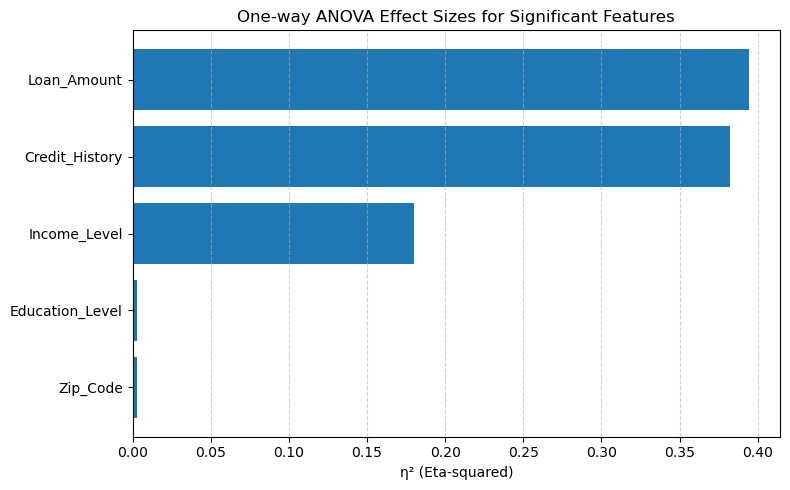

In [77]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.barh(sig_df["Feature"], sig_df["Eta_squared"])
plt.xlabel("η² (Eta-squared)")
plt.title("One-way ANOVA Effect Sizes for Significant Features")
plt.gca().invert_yaxis()  # largest η² on top
plt.grid(axis="x", linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

In [79]:
def compute_feature_recovery_metrics(gt, ranking):
    """
    Compute TP, FP, FN, Precision, Recall, FDR, and Top-1 Match for feature recovery.

    Parameters
    ----------
    gt : set
        Ground-truth causal features.
    flagged : list or set
        Features your method flagged as important (e.g., top‑k from ranking).
    ranking : list
        Ordered list of features by descending effect size.

    Returns
    -------
    pd.DataFrame
        Single-row DataFrame with the metrics.
    """
    tp = set(gt) & set(ranking)
    fp = set(ranking) - set(gt)
    fn = set(gt) - set(ranking)

    precision = len(tp) / (len(tp) + len(fp)) if (len(tp) + len(fp)) else 0.0
    recall    = len(tp) / len(gt)        if len(gt)              else 0.0
    fdr       = len(fp) / (len(tp) + len(fp)) if (len(tp) + len(fp)) else 0.0
    top1      = 1 if ranking and ranking[0] in gt else 0

    metrics = {
        "TP":           ", ".join(sorted(tp)),
        "FP":           ", ".join(sorted(fp)),
        "FN":           ", ".join(sorted(fn)),
        "Precision":     precision,
        "Recall":        recall,
        "FDR":           fdr,
        "Top-1 Match":   top1
    }
    return pd.DataFrame([{
        "Precision": precision,
        "Recall": recall,
        "FDR": fdr,
        "Top-1 Match": top1
    }])



if __name__ == "__main__":
    # Example:
    GT = {"Loan_Amount", "Credit_History", "Income_Level"}
    ranking = [
        "Loan_Amount",
        "Credit_History",
        "Income_Level",
        "Education_Level",
        "Zip_Code"
    ]
    # flagged = ranking[:3]  # e.g. top‑3 features

    df_metrics = compute_feature_recovery_metrics(GT, ranking)
    df_metrics.insert(0, "Method", "Stat-XAI")
    df_metrics = df_metrics[["Method", "Precision", "Recall", "FDR", "Top-1 Match"]]
    print(df_metrics.to_string(index=False))

  Method  Precision  Recall  FDR  Top-1 Match
Stat-XAI        0.6     1.0  0.4            1


In [88]:
import shap
import numpy as np
import psutil
import os
import torch.optim as optim
import matplotlib.pyplot as plt

In [90]:
def predict_proba_np(x_np):
    """
    x_np: np.array of shape (batch, 5), dtype int
    returns: np.array of shape (batch,) with predicted positive‐class probabilities
    """
    model.eval()
    with torch.no_grad():
        tensor = torch.LongTensor(x_np).to(device)
        logits = model(tensor)
        probs  = torch.sigmoid(logits).cpu().numpy().flatten()
    return probs

In [92]:
bg_size    = 100
bg_idx     = np.random.choice(len(X_train), size=bg_size, replace=False)
background = X_train[bg_idx] 

In [94]:
explainer = shap.KernelExplainer(predict_proba_np, background)



In [96]:
batch_size = 512
all_shap   = []


In [98]:
for start in range(0, len(X_test), batch_size):
    end    = min(start + batch_size, len(X_test))
    Xb_np  = X_test[start:end]
    
    mem = psutil.virtual_memory()
    print(f"Batch {start}-{end}: free RAM {mem.available/1e9:.2f} GB")
    
    # nsamples controls speed/accuracy
    shap_vals_batch = explainer.shap_values(Xb_np, nsamples=100)
    all_shap.append(shap_vals_batch)


Batch 0-512: free RAM 3.83 GB


  0%|          | 0/512 [00:00<?, ?it/s]

Batch 512-1024: free RAM 3.96 GB


  0%|          | 0/512 [00:00<?, ?it/s]

Batch 1024-1536: free RAM 3.71 GB


  0%|          | 0/512 [00:00<?, ?it/s]

Batch 1536-2048: free RAM 3.73 GB


  0%|          | 0/512 [00:00<?, ?it/s]

Batch 2048-2560: free RAM 3.79 GB


  0%|          | 0/512 [00:00<?, ?it/s]

Batch 2560-3000: free RAM 3.79 GB


  0%|          | 0/440 [00:00<?, ?it/s]

In [100]:
all_shap_values = np.vstack(all_shap)

In [102]:
mean_abs = pd.Series(
    np.abs(all_shap_values).mean(axis=0),
    index=features
).sort_values()

In [104]:
mean_abs

Education_Level    0.001350
Zip_Code           0.001528
Income_Level       0.014508
Credit_History     0.015034
Loan_Amount        0.015578
dtype: float64

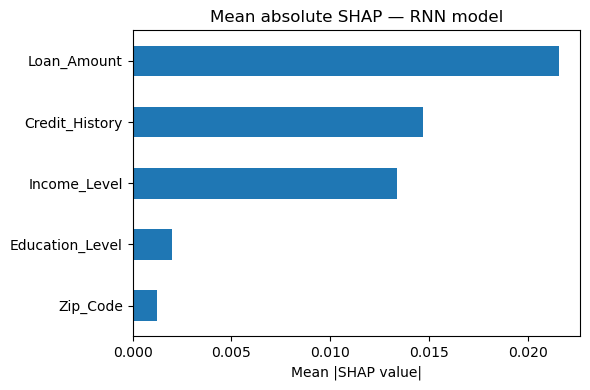

In [52]:
os.makedirs("shap", exist_ok=True)
plt.figure(figsize=(6,4))
mean_abs.plot.barh()
plt.xlabel("Mean |SHAP value|")
plt.title("Mean absolute SHAP — RNN model")
plt.tight_layout()
plt.savefig("shap/RNN_categorical_continous_shap_summary.jpg", dpi=300)
plt.show()

In [48]:
def compute_feature_recovery_metrics(gt, ranking):
    """
    Compute TP, FP, FN, Precision, Recall, FDR, and Top-1 Match for feature recovery.

    Parameters
    ----------
    gt : set
        Ground-truth causal features.
    flagged : list or set
        Features your method flagged as important (e.g., top‑k from ranking).
    ranking : list
        Ordered list of features by descending effect size.

    Returns
    -------
    pd.DataFrame
        Single-row DataFrame with the metrics.
    """
    tp = set(gt) & set(ranking)
    fp = set(ranking) - set(gt)
    fn = set(gt) - set(ranking)

    precision = len(tp) / (len(tp) + len(fp)) if (len(tp) + len(fp)) else 0.0
    recall    = len(tp) / len(gt)        if len(gt)              else 0.0
    fdr       = len(fp) / (len(tp) + len(fp)) if (len(tp) + len(fp)) else 0.0
    top1      = 1 if ranking and ranking[0] in gt else 0

    metrics = {
        "TP":           ", ".join(sorted(tp)),
        "FP":           ", ".join(sorted(fp)),
        "FN":           ", ".join(sorted(fn)),
        "Precision":     precision,
        "Recall":        recall,
        "FDR":           fdr,
        "Top-1 Match":   top1
    }
    return pd.DataFrame([{
        "Precision": precision,
        "Recall": recall,
        "FDR": fdr,
        "Top-1 Match": top1
    }])




In [50]:
if __name__ == "__main__":
    # Example:
    GT = {"Loan_Amount", "Credit_History", "Income_Level"}
    ranking = [
        "Loan_Amount",
        "Credit_History",
        "Income_Level",
    "Education_Level",
    "Zip_Code"]
    # flagged = ranking[:3]  # e.g. top‑3 features

    df_metrics = compute_feature_recovery_metrics(GT, ranking)
    df_metrics.insert(0, "Method", "SHAP-XAI")
    df_metrics = df_metrics[["Method", "Precision", "Recall", "FDR", "Top-1 Match"]]
    print(df_metrics.to_string(index=False))

  Method  Precision  Recall  FDR  Top-1 Match
SHAP-XAI        0.6     1.0  0.4            1
